## main qualitative comparison

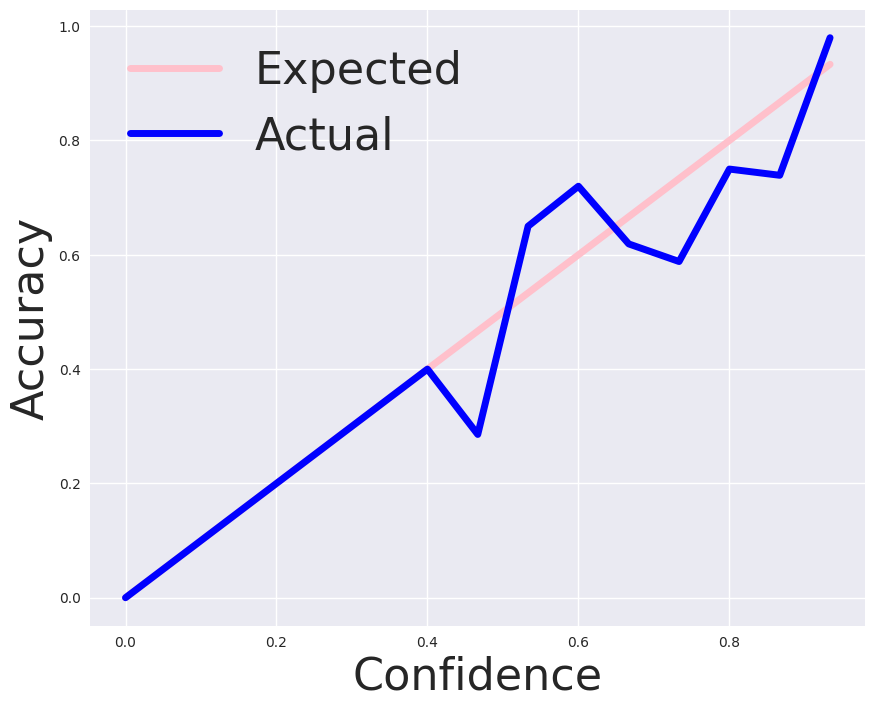

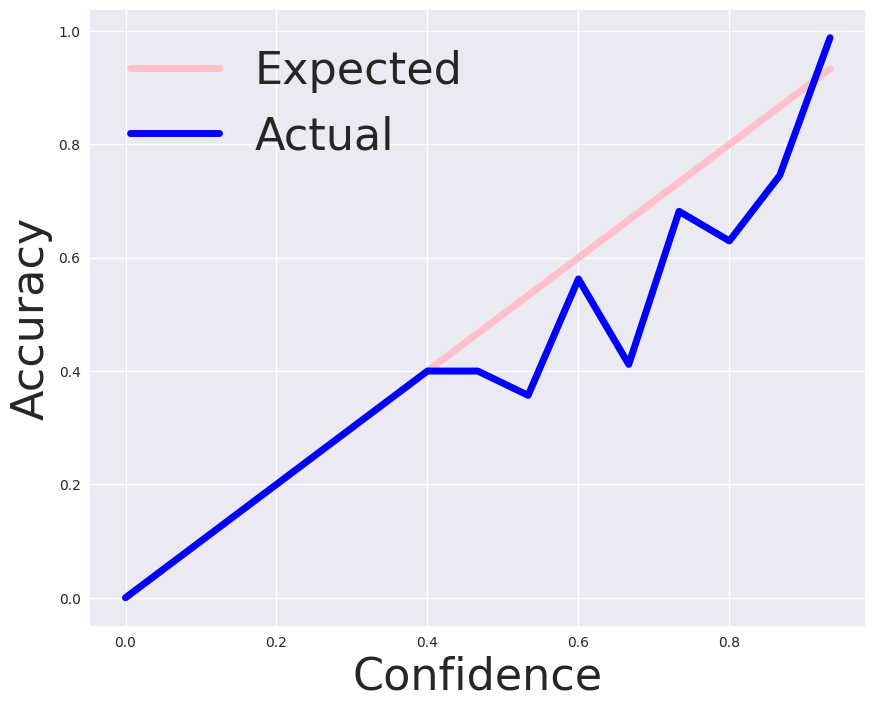

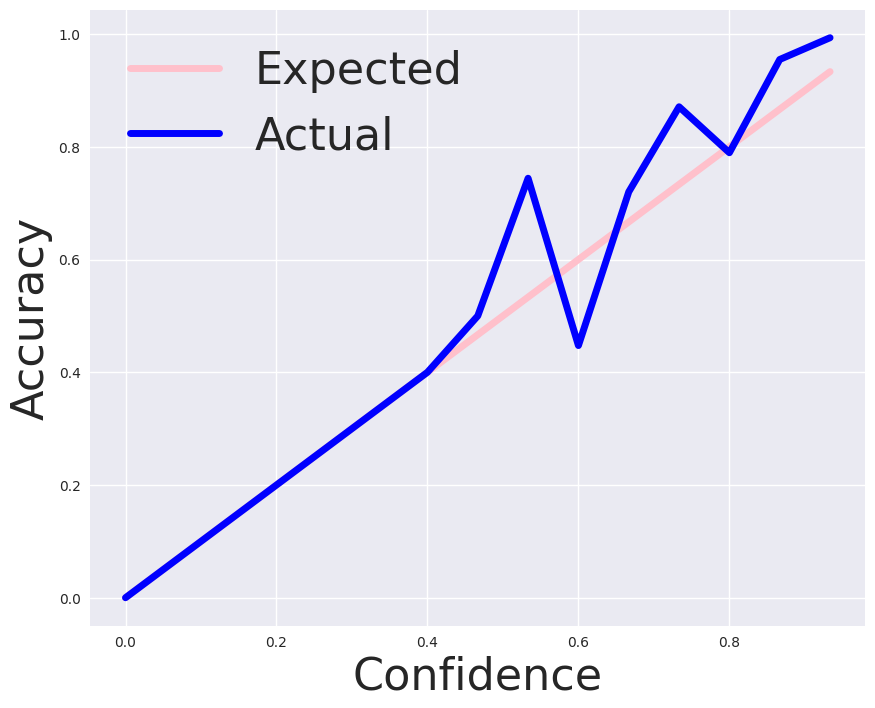

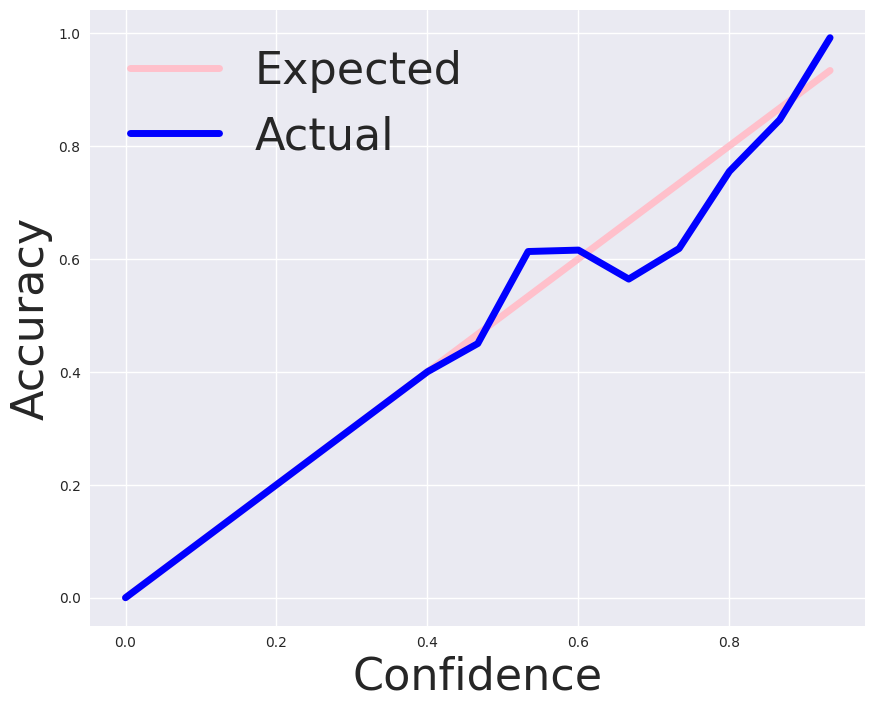

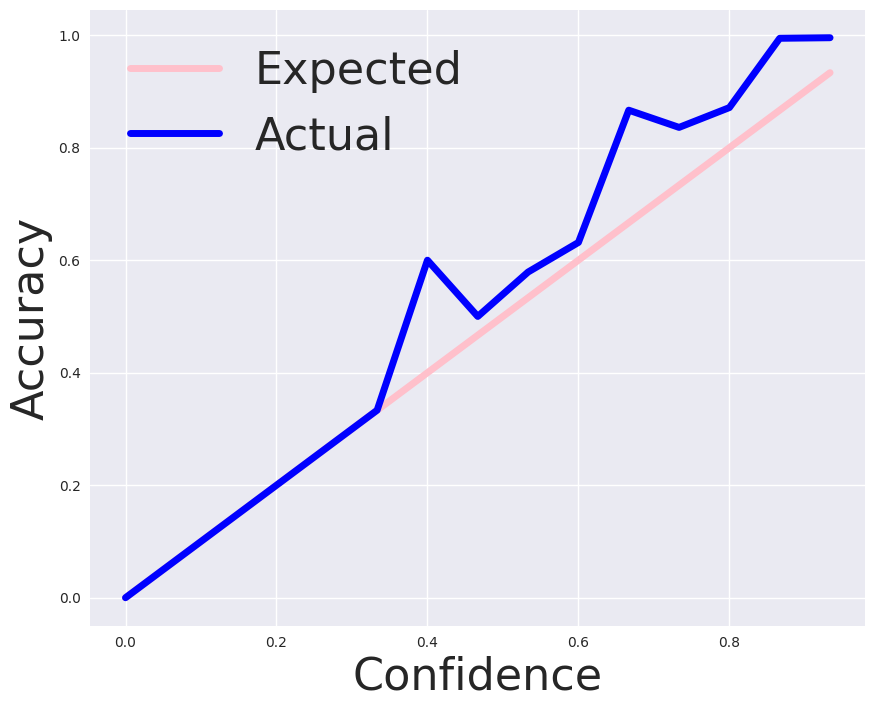

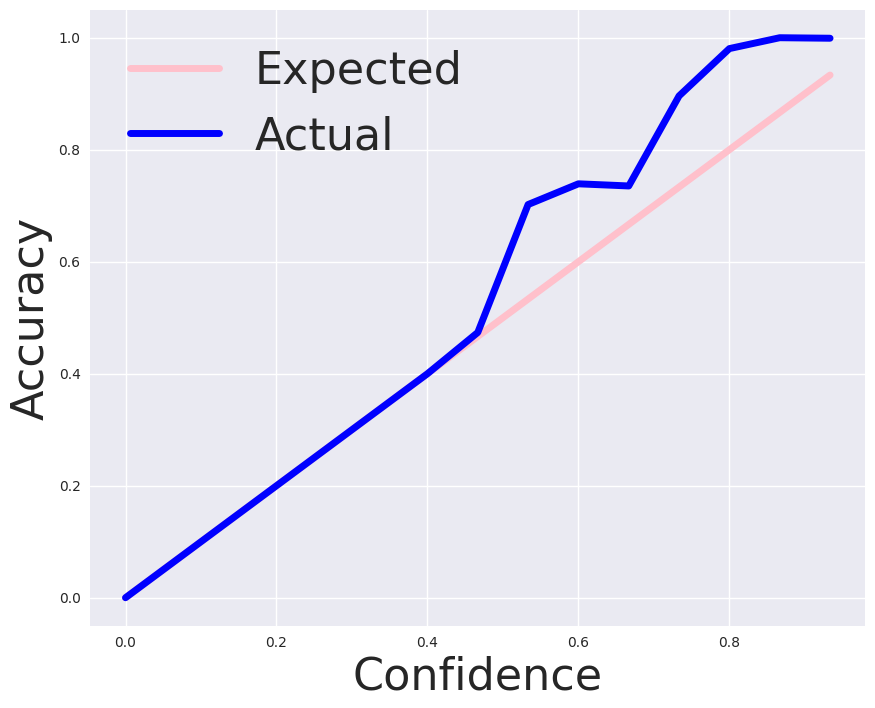

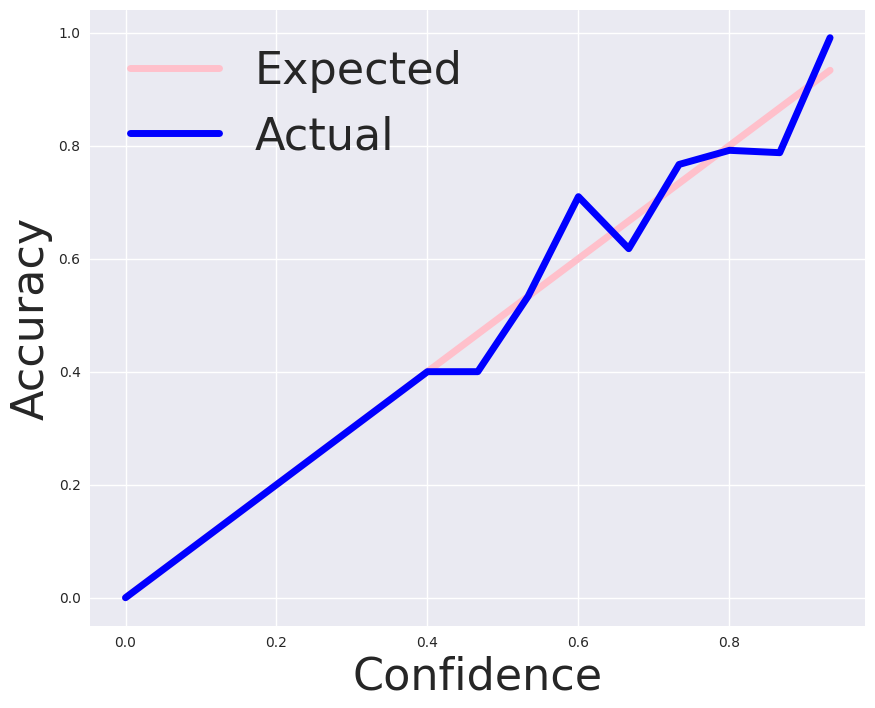

In [53]:
import glob
from calibrate.net.unet import UNet
import numpy as np
import torch
from tqdm import tqdm
import h5py
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd
from utils import *
from common import *
# from calibrate.evaluation.reliability_diagram import ReliabilityDiagram


if __name__ == "__main__":
    

    # dataset_type = "acdc"
    # fname = '223.h5'
    # sno = None   
    
#     dataset_type = "mrbrains"
#     fname = "0.h5" 
#     sno = 25
    
    dataset_type = "flare"
    fname = "train_178.h5" 
    sno = 17
    
#     dataset_type = "brats"
#     fname = "BRATS_456.h5" 
#     sno = 5
    
    # dataset_type = "refuge"
    # fname = 'T0251.h5'
    # sno = None 

    # dataset_type = "promise_mc"
    # fname = "prostate_46.h5" 
    # sno = 4
    
    savedir = '/home/ar88770/figures_mbls/' + '{}'.format(dataset_type)
    
    if not os.path.exists(savedir):
        os.mkdir(savedir)
        
    
    params = get_params(dataset_type)
    method_names =['ce','ce_dice','focal','penalty','ls','svls','margin']
    fpath = os.path.join(params.data_root,'test',fname)
    models_path = [params.model_path_ce, params.model_path_ce_dice, params.model_path_focal, params.model_path_penalty, 
                   params.model_path_ls, params.model_path_svls, params.model_path_margin]
    model = UNet(input_channels=params.in_channels, num_classes=params.nclasses)
    
    
    ii = 1
    for key, model_path in zip(method_names,models_path):

        checkpoint = torch.load(model_path)["state_dict"]
        checkpoint = dict((key[7:] if "module" in key else key, value)for (key, value) in checkpoint.items())
        model.load_state_dict(checkpoint)
        model = model.to('cuda:4')
        
        with h5py.File(fpath, 'r') as data:

            img = data["img"][:]
            mask = data["mask"][:]

        img, mask = pre_process_data(img, mask, dataset_type, sno=sno)
        
        plt.imsave(os.path.join(savedir,'img.png'),img[0],cmap='gray')
        plt.imsave(os.path.join(savedir,'mask.png'),mask, cmap='gray')

        imgT = torch.from_numpy(img)
        imgT = imgT.unsqueeze(0)
        imgT = imgT.cuda('cuda:4')

        target = np.expand_dims(mask,axis=0)
        targetT = torch.from_numpy(target)

        predT = model(imgT.float()).detach().cpu() 
        outputconf = F.softmax(predT,dim=1).numpy()[0]
        output = np.argmax(outputconf,axis=0)
    
        dsc, _ = metric_multi_class(output, targetT.numpy()[0])

        plt.imsave(os.path.join(savedir, 'mask_{}.png'.format(key)), output, cmap='gray')
        
        outputconf = np.transpose(outputconf, [1,2,0])
        x, y, c = outputconf.shape
        outputconf = outputconf.reshape(x * y, -1)
        mask = mask.reshape(x * y)
        output = output.reshape(x * y)
        
        idx = mask > 0
        outputconf = outputconf[idx]
        label = mask[idx]
        output = output[idx]
        maxconf = np.max(outputconf, axis=1)
        
        n, c, x, y = predT.shape
        
        logits = torch.einsum("ncxy->nxyc", predT)
        logits = logits.reshape(n * x * y, -1)
        labels = targetT.reshape(n * x * y)
        logits = logits[idx]
        labels = labels[idx]
        
        ece = expected_calibration_error(maxconf, output, label)
        
        reliability_curve_save(maxconf, output, label, os.path.join(savedir,'rc_{}.png'.format(key)))
        
        ii = ii + 1

## architecture box diagram

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# unet_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/unet-ce-adam/20220619-21:08:32-970895/metrics.csv'
# unet_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/unet-logit_margin-adam/20220624-05:40:30-578821/metrics.csv'
# unetpp_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/unetpp-ce-adam/20220704-22:27:24-517023/metrics.csv'
# unetpp_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/unetpp-logit_margin-adam/20220705-02:00:12-035540/metrics.csv'
# transunet_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/transunet-ce-adam/20220704-22:40:20-107011/metrics.csv'
# transunet_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/transunet-logit_margin-adam/20220705-00:20:45-298901/metrics.csv'
# attunet_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/attunet-ce-adam/20220705-14:34:34-484315/metrics.csv'
# attunet_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/attunet-logit_margin-adam/20220705-16:06:35-824150/metrics.csv'


unet_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/unet-ce-adam/20220619-21:08:32-970895/metrics3d.csv'
unet_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/unet-logit_margin-adam/20220624-05:40:30-578821/metrics3d.csv'
unetpp_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/unetpp-ce-adam/20220704-22:27:24-517023/metrics3d.csv'
unetpp_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/unetpp-logit_margin-adam/20220705-02:00:12-035540/metrics3d.csv'
transunet_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/transunet-ce-adam/20220704-22:40:20-107011/metrics3d.csv'
transunet_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/transunet-logit_margin-adam/20220705-00:20:45-298901/metrics3d.csv'
attunet_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/attunet-ce-adam/20220705-14:34:34-484315/metrics3d.csv'
attunet_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/attunet-logit_margin-adam/20220705-16:06:35-824150/metrics3d.csv'



metrics_paths = [(unet_model_path_ce, unet_model_path_margin), (unetpp_model_path_ce, unetpp_model_path_margin), 
                 (transunet_model_path_ce, transunet_model_path_margin), (attunet_model_path_ce, attunet_model_path_margin)]
# metrics_paths = [(unet_model_path_ce, unet_model_path_margin), (unetpp_model_path_ce, unetpp_model_path_margin), (transunet_model_path_ce, transunet_model_path_margin)]
model_types = ['UNet', 'UNet++', 'TransUNet', 'AttUNet']

dict_new = {'DICE':[], 'Method':[], 'ECE':[], 'Models':[]}

for model_type, metricpath in zip(model_types,metrics_paths):
    
    df_ce = pd.read_csv(metricpath[0])
    df_margin = pd.read_csv(metricpath[1])    
    dsc_ce, dsc_margin = df_ce['dsc'].to_list(), df_margin['dsc'].to_list()
    ece_ce, ece_margin = df_ce['ece'].to_list(), df_margin['ece'].to_list()
    cnt = len(dsc_ce)
    dict_new['DICE'] += dsc_ce + dsc_margin
    dict_new['ECE'] += ece_ce + ece_margin
    dict_new['Method'] += ['CE']*cnt + ['Ours']*cnt
    dict_new['Models'] += [model_type]*2*cnt 
    
df_new = pd.DataFrame(dict_new)

plt.figure()
sns.boxplot(x="Models", y="DICE", hue="Method", data=df_new, showfliers=False, order=['UNet', 'AttUNet', 'TransUNet', 'UNet++'])
plt.savefig('../../figures_mbls/flare/arch_dsc.png',bbox_inches='tight')

plt.figure()
sns.boxplot(x="Models", y="ECE", hue="Method", data=df_new,showfliers=False,order=['UNet', 'AttUNet', 'TransUNet', 'UNet++'])
plt.savefig('../../figures_mbls/flare/arch_ece.png',bbox_inches='tight')

In [ ]:
import glob
from calibrate.net.unet import UNet
from segmentation_models_pytorch import UnetPlusPlus
from calibrate.net.vit_seg_modeling import transfomer_model
from calibrate.net.attunet import AttU_Net
import numpy as np
import torch
from tqdm import tqdm
import h5py
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd
from utils import *
from common import *
# from calibrate.evaluation.reliability_diagram import ReliabilityDiagram

if __name__ == "__main__":
    

    dataset_type = "flare"
    fname = 'train_107.h5'
    sno = 13
    
    savedir = '/home/ar88770/figures_mbls/' + '{}'.format(dataset_type)
    
    method_names =['ce','margin']
    model_choice = 2 # (0-unet, 1-unetpp, 2-attunet, 3-transunet)
    
    params = get_params(dataset_type)
    fpath = os.path.join(params.data_root,fname)
    
    model_path_ce = ['/home/ar88770/MarginLoss/outputs/abdomen/unet-ce-adam/20220501-23:43:11-336368/best.pth',
                     '/home/ar88770/MarginLoss/outputs/abdomen/unetpp-ce-adam/20220503-08:58:27-961344/best.pth',
                     '/home/ar88770/MarginLoss/outputs/abdomen/attunet-ce-adam/20220512-12:13:19-280852/best.pth',
                     '/home/ar88770/MarginLoss/outputs/abdomen/transunet-ce-adam/20220503-17:50:32-275714/best.pth']
                     
    model_path_margin = ['/home/ar88770/MarginLoss/outputs/abdomen/unet-logit_margin-adam/20220502-07:01:38-850966/best.pth', 
                         '/home/ar88770/MarginLoss/outputs/abdomen/unetpp-logit_margin-adam/20220503-12:56:36-184488/best.pth',
                         '/home/ar88770/MarginLoss/outputs/abdomen/attunet-logit_margin-adam/20220512-22:30:26-873645/best.pth',
                         '/home/ar88770/MarginLoss/outputs/abdomen/transunet-logit_margin-adam/20220504-08:48:50-840940/best.pth']    
    
    # diagram = ReliabilityDiagram(bins=25, style="curve")
    
    with h5py.File(fpath, 'r') as data:
        img = data["img"][:]
        mask = data["mask"][:]

    img, mask = pre_process_data(img, mask, dataset_type, sno=sno)
    imgT = torch.from_numpy(img)
    imgT = imgT.unsqueeze(0)
    imgT = imgT.cuda('cuda:4')
    maskT = torch.from_numpy(mask)
    maskT = maskT.unsqueeze(0)
    
    ii = 0

    mdlnames = ['unet','unetpp','attunet','transunet']
    mdlname = mdlnames[model_choice]
    
    if not os.path.exists(os.path.join(savedir, mdlname)):
        os.mkdir(os.path.join(savedir, mdlname))
    
    plt.imsave(os.path.join(savedir,mdlname, 'img.png'),np.flipud(img[0]),cmap='gray')
    plt.imsave(os.path.join(savedir,mdlname, 'mask.png'),np.flipud(mask),cmap='gray')
    
    for model1, model2 in zip(model_path_ce,model_path_margin):
        
        if not ii == model_choice:
            ii = ii + 1
            continue
        
        model1_bdir = os.path.dirname(model1)
        model2_bdir = os.path.dirname(model2)

#         metric1_path = os.path.join(model1_bdir, 'metrics.csv')
#         metric2_path = os.path.join(model2_bdir, 'metrics.csv')
        
#         csv1 = pd.read_csv(metric1_path)
#         print (csv1[(csv1['fname'] == fname) & (csv1['sno'] == sno)])
#         csv2 = pd.read_csv(metric2_path)
#         print (csv2[(csv2['fname'] == fname) & (csv2['sno'] == sno)])
        
        print (model1, model2)

        if ii == 0:
            model = UNet(input_channels=params.in_channels, num_classes=params.nclasses)
        if ii == 1:
            model = UnetPlusPlus(in_channels=params.in_channels, classes=params.nclasses)
        if ii == 2:
            model = AttU_Net(img_ch=params.in_channels, output_ch=params.nclasses)
        if ii == 3:
            model = transfomer_model(model_name='R50-ViT-B_16', img_size=192, vit_patches_size=16, n_classes=params.nclasses)
        
        checkpoint = torch.load(model1)["state_dict"]
        checkpoint = dict((key[7:] if "module" in key else key, value)for (key, value) in checkpoint.items())
        model.load_state_dict(checkpoint)
        model = model.to('cuda:4')
        
        predT = model(imgT.float()).detach().cpu() 
        outputconf = F.softmax(predT,dim=1).numpy()[0]
        output = np.argmax(outputconf,axis=0)
        dsc, _ = metric_multi_class(output, maskT.numpy()[0])
    
        plt.imsave(os.path.join(savedir,mdlname, 'mask_ce.png'),np.flipud(output),cmap='gray')
        
        outputconf = np.transpose(outputconf, [1,2,0])
        x, y, c = outputconf.shape
        outputconf = outputconf.reshape(x * y, -1)
        mask = mask.reshape(x * y)
        output = output.reshape(x * y)
        
        outputconf = outputconf[mask>0]
        label = mask[mask>0]
        output = output[mask>0]
        maxconf = np.max(outputconf, axis=1)
        
        ece = expected_calibration_error(maxconf, output, label)
        
        reliability_curve_save(maxconf, output, label, os.path.join(savedir,mdlname, 'rc_ce.png'))

        checkpoint = torch.load(model2)["state_dict"]
        checkpoint = dict((key[7:] if "module" in key else key, value)for (key, value) in checkpoint.items())
        model.load_state_dict(checkpoint)
        model = model.to('cuda:4')
        
        predT = model(imgT.float()).detach().cpu() 
        outputconf = F.softmax(predT,dim=1).numpy()[0]
        output = np.argmax(outputconf,axis=0)
        dsc, _ = metric_multi_class(output, maskT.numpy()[0])
        
        plt.imsave(os.path.join(savedir,mdlname, 'mask_margin.png'),np.flipud(output),cmap='gray')
        
        outputconf = np.transpose(outputconf, [1,2,0])
        x, y, c = outputconf.shape
        outputconf = outputconf.reshape(x * y, -1)
        mask = mask.reshape(x * y)
        output = output.reshape(x * y)
        
        outputconf = outputconf[mask>0]
        label = mask[mask>0]
        output = output[mask>0]
        maxconf = np.max(outputconf, axis=1) 
        
        ece = expected_calibration_error(maxconf, output, label)
        
        reliability_curve_save(maxconf, output, label, os.path.join(savedir,mdlname, 'rc_margin.png'))
        
        ii = ii + 1
        
        # break


In [ ]:
import glob
from calibrate.net.unet import UNet
import numpy as np
import torch
from tqdm import tqdm
import h5py
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd
from utils import *
from common import *
# from calibrate.evaluation.reliability_diagram import ReliabilityDiagram
from calibrate.evaluation.ood_test_utils import entropy

if __name__ == "__main__":
    

    # dataset_type = "acdc"
    # fname = '396.h5'
    # sno = None     
    
    # dataset_type = "acdc"
    # fname = '287.h5'
    # sno = None  
    
    dataset_type = "mrbrains"
    fname = "0.h5" 
    sno = 24
    
    # dataset_type = "flare"
    # fname = 'train_198.h5'
    # sno = 10
    
    # dataset_type = "brats"
    # fname = "BRATS_456.h5" 
    # sno = 6

    # dataset_type = "refuge"
    # fname = 'T0337.h5'
    # sno = None 

    # dataset_type = "promise_mc"
    # fname = "prostate_46.h5" 
    # sno = 4
    
    params = get_params(dataset_type)
    method_names =['CE','CE+DSC','FL','ECP','LS','SVLS','Ours']
    fpath = os.path.join(params.data_root,fname)
    models_path = [params.model_path_ce, params.model_path_ce_dice, params.model_path_focal, params.model_path_penalty, 
                   params.model_path_ls, params.model_path_svls, params.model_path_margin]
    model = UNet(input_channels=params.in_channels, num_classes=params.nclasses)
    
    # diagram = ReliabilityDiagram(bins=25, style="curve")
    
    with h5py.File(fpath, 'r') as data:

        img = data["img"][:]
        mask = data["mask"][:].astype(int)
    
    img, mask = pre_process_data(img, mask, dataset_type, sno=sno)

    for cno in np.unique(mask)[1:]:
        
        plt.figure(figsize=(25,25))
        plt.subplot(1,8,1)
        plt.imshow(mask == cno)
        plt.xticks([])
        plt.yticks([])
        plt.title('mask')
        
        ii = 2
        for key, model_path in zip(method_names,models_path):

            checkpoint = torch.load(model_path)["state_dict"]
            checkpoint = dict((key[7:] if "module" in key else key, value)for (key, value) in checkpoint.items())
            model.load_state_dict(checkpoint)
            model = model.to('cuda:4')

            imgT = torch.from_numpy(img)
            imgT = imgT.unsqueeze(0)
            imgT = imgT.cuda('cuda:4')

            # target = np.expand_dims(mask,axis=0)
            # targetT = torch.from_numpy(target)
            # targetT = targetT.cuda('cuda:4')

            predT = model(imgT.float()).detach().cpu() 
            entr = entropy(predT).numpy()[0]
            outputconf = F.softmax(predT,dim=1).numpy()[0]
            output = np.argmax(outputconf,axis=0)

            # print (outputconf.shape, label.shape, output.shape, maxconf.shape)

            plt.subplot(1,8,ii)
            plt.imshow(outputconf[cno], cmap='jet',vmin=0, vmax=1)
            plt.xticks([])
            plt.yticks([])
            # plt.title(key)

            ii = ii + 1
            # bin_strength_plot(maxconf, output, label, key)

            # fig_reliab = diagram.plot(outputconf, mask)

            # plt.show()

In [ ]:
import glob
from calibrate.net.unet import UNet
import numpy as np
import torch
from tqdm import tqdm
import h5py
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd
from utils import *
from common import *
# from calibrate.evaluation.reliability_diagram import ReliabilityDiagram


if __name__ == "__main__":
    

    # dataset_type = "acdc"
    # fname = '223.h5'
    # sno = None   
    
    dataset_type = "mrbrains"
    fname = "0.h5" 
    sno = 25
    
#     dataset_type = "flare"
#     fname = "train_178.h5" 
#     sno = 17
    
#     dataset_type = "brats"
#     fname = "BRATS_456.h5" 
#     sno = 5
    
    # dataset_type = "refuge"
    # fname = 'T0251.h5'
    # sno = None 

    # dataset_type = "promise_mc"
    # fname = "prostate_46.h5" 
    # sno = 4
    
    savedir = '/home/ar88770/figures_mbls/confidencemap/' + '{}'.format(dataset_type)
    
    if not os.path.exists(savedir):
        os.mkdir(savedir)
        
    
    params = get_params(dataset_type)
    method_names =['ce','ce_dice','focal','penalty','ls','svls','margin']
    fpath = os.path.join(params.data_root,fname)
    models_path = [params.model_path_ce, params.model_path_ce_dice, params.model_path_focal, params.model_path_penalty, 
                   params.model_path_ls, params.model_path_svls, params.model_path_margin]
    model = UNet(input_channels=params.in_channels, num_classes=params.nclasses)
    
    with h5py.File(fpath, 'r') as data:

        img = data["img"][:]
        mask = data["mask"][:]

    img, mask = pre_process_data(img, mask, dataset_type, sno=sno)

    plt.imsave(os.path.join(savedir,'img.png'),img[0],cmap='gray')
    plt.imsave(os.path.join(savedir,'mask.png'),mask, cmap='gray')
    
    
    for key, model_path in zip(method_names,models_path):

        checkpoint = torch.load(model_path)["state_dict"]
        checkpoint = dict((key[7:] if "module" in key else key, value)for (key, value) in checkpoint.items())
        model.load_state_dict(checkpoint)
        model = model.to('cuda:4')

        imgT = torch.from_numpy(img)
        imgT = imgT.unsqueeze(0)
        imgT = imgT.cuda('cuda:4')

        target = np.expand_dims(mask,axis=0)
        targetT = torch.from_numpy(target)

        predT = model(imgT.float()).detach().cpu() 
        outputconf = F.softmax(predT,dim=1).numpy()[0]
        
        for cno in np.unique(mask)[1:]:   
            plt.imsave(os.path.join(savedir, 'mask_{}_{}.png'.format(cno,key)), outputconf[cno],cmap='jet',vmin=0, vmax=1)

## updated boxplot for different architectures

In [ ]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# unet_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/unet-ce-adam/20220619-21:08:32-970895/metrics.csv'
# unet_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/unet-logit_margin-adam/20220624-05:40:30-578821/metrics.csv'
# unetpp_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/unetpp-ce-adam/20220704-22:27:24-517023/metrics.csv'
# unetpp_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/unetpp-logit_margin-adam/20220705-02:00:12-035540/metrics.csv'
# transunet_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/transunet-ce-adam/20220704-22:40:20-107011/metrics.csv'
# transunet_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/transunet-logit_margin-adam/20220705-00:20:45-298901/metrics.csv'
# attunet_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/attunet-ce-adam/20220705-14:34:34-484315/metrics.csv'
# attunet_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/attunet-logit_margin-adam/20220705-16:06:35-824150/metrics.csv'


unet_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/unet-ce-adam/20220619-21:08:32-970895/metrics3d.csv'
unet_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/unet-logit_margin-adam/20220624-05:40:30-578821/metrics3d.csv'
unetpp_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/unetpp-ce-adam/20220704-22:27:24-517023/metrics3d.csv'
unetpp_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/unetpp-logit_margin-adam/20220705-02:00:12-035540/metrics3d.csv'
transunet_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/transunet-ce-adam/20220704-22:40:20-107011/metrics3d.csv'
transunet_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/transunet-logit_margin-adam/20220705-00:20:45-298901/metrics3d.csv'
attunet_model_path_ce = '/home/ar88770/MarginLoss/outputs/abdomen/attunet-ce-adam/20220705-14:34:34-484315/metrics3d.csv'
attunet_model_path_margin = '/home/ar88770/MarginLoss/outputs/abdomen/attunet-logit_margin-adam/20220705-16:06:35-824150/metrics3d.csv'



metrics_paths = [(unet_model_path_ce, unet_model_path_margin), (unetpp_model_path_ce, unetpp_model_path_margin), 
                 (transunet_model_path_ce, transunet_model_path_margin), (attunet_model_path_ce, attunet_model_path_margin)]
# metrics_paths = [(unet_model_path_ce, unet_model_path_margin), (unetpp_model_path_ce, unetpp_model_path_margin), (transunet_model_path_ce, transunet_model_path_margin)]
model_types = ['UNet', 'UNet++', 'TransUNet', 'AttUNet']

dict_new = {'DICE':[], 'Method':[], 'ECE':[], 'Models':[]}

for model_type, metricpath in zip(model_types,metrics_paths):
    
    df_ce = pd.read_csv(metricpath[0])
    df_margin = pd.read_csv(metricpath[1])    
    dsc_ce, dsc_margin = df_ce['dsc'].to_list(), df_margin['dsc'].to_list()
    ece_ce, ece_margin = df_ce['ece'].to_list(), df_margin['ece'].to_list()
    cnt = len(dsc_ce)
    dict_new['DICE'] += dsc_ce + dsc_margin
    dict_new['ECE'] += ece_ce + ece_margin
    dict_new['Method'] += ['CE']*cnt + ['Ours']*cnt
    dict_new['Models'] += [model_type]*2*cnt 
    
df_new = pd.DataFrame(dict_new)

plt.figure()
plt.style.use('ggplot')
sns.boxplot(x="Models", y="DICE", hue="Method", data=df_new, palette="pastel",
            showfliers=False, order=['UNet', 'AttUNet', 'TransUNet', 'UNet++'])
plt.savefig('../../figures_mbls/flare/arch_dsc.png',bbox_inches='tight')

plt.figure()
sns.boxplot(x="Models", y="ECE", hue="Method", data=df_new, palette="pastel",
            showfliers=False,order=['UNet', 'AttUNet', 'TransUNet', 'UNet++'])
plt.savefig('../../figures_mbls/flare/arch_ece.png',bbox_inches='tight')

In [ ]:
## updated radar plot for different methods

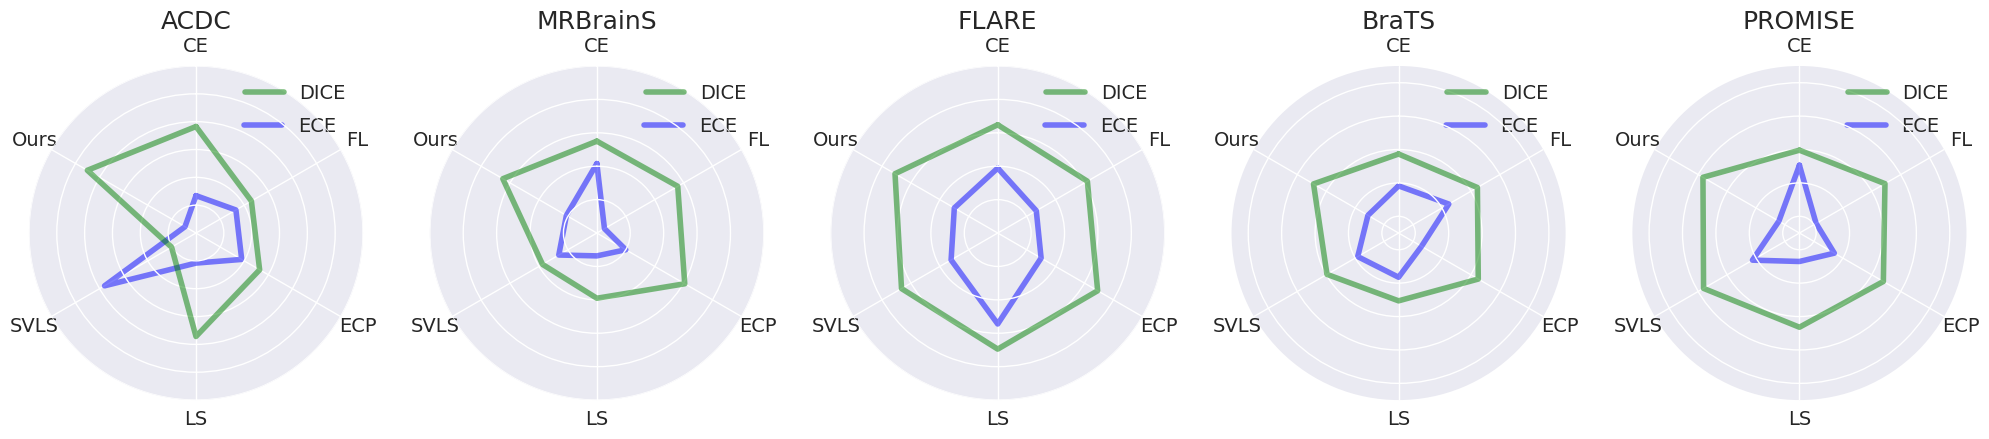

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def main(r1, r2,title, vals, ax, ii):
    
    ax[ii].set_title(title,fontsize=18)
    ax[ii].set_thetagrids(range(0, 360, int(360/len(methods))), (methods))
    ax[ii].yaxis.set_visible(False)
    ax[ii].tick_params(labelsize=14)

    ax2 = polar_twin(ax[ii])

    ax[ii].plot(theta, r2, color='blue', alpha=0.5, linewidth=4)
    ax[ii].legend(['ECE'],loc=6,bbox_to_anchor=(0.59, 0.82),fontsize=14)
    ax2.plot(theta, r1, color='green', alpha=0.5, linewidth=4)
    ax2.legend(['DICE'],loc=1,fontsize=14)

    ax2.set_ylim(vals[0], vals[1])
    ax[ii].set_ylim(vals[2], vals[3])
    
    return

def polar_twin(ax):
    ax2 = ax.figure.add_axes(ax.get_position(), projection='polar', 
                             label='twin', frameon=False,
                             theta_direction=ax.get_theta_direction(),
                             theta_offset=ax.get_theta_offset())
    ax2.xaxis.set_visible(False)
    ax2.yaxis.set_visible(True)
    ax2.set_yticklabels([])

    # There should be a method for this, but there isn't... Pull request?
    # ax2._r_label_position._t = (22.5 + 180, 360)
    # ax2._r_label_position.invalidate()

    # Bit of a hack to ensure that the original axes tick labels are on top of
    # whatever is plotted in the twinned axes. Tick labels will be drawn twice.
    # for label in ax.get_yticklabels():
    #     ax.figure.texts.append(label)

    return ax2

if __name__ == '__main__':
    
    # dice_acdc = [0.828,0.86,0.854,0.875,0.818,0.893,0.828]
    # dice_mrbrain = [0.788,0.755,0.787,0.748,0.745,0.812,0.788]
    # dice_brats = [0.775,0.75,0.747,0.765,0.781,0.769,0.775]
    # dice_promise = [0.565,0.301,0.584,0.59,0.597,0.625,0.565]
    # # dice_refuge = [0.891,0.875,0.892,0.894,0.888,0.8868,0.891]
    # dice_abdomen = [0.871, 0.876, 0.881, 0.889, 0.879, 0.886,0.871]
    
    # ece_acdc = [0.121,0.133,0.104,0.106,0.132,0.076,0.121]
    # ece_mrbrain = [0.09, 0.105, 0.049, 0.037, 0.06, 0.051,0.09]
    # ece_brats = [0.114,0.127,0.103,0.09,0.09,0.086,0.114]
    # ece_promise = [0.294,0.469,0.288,0.211,0.195,0.241,0.294]
    # # ece_refuge = [0.032,0.04,0.037,0.06,0.029,0.033,0.032]
    # ece_abdomen = [0.0492,0.0288,0.0452,0.0491,0.03289,0.0423,0.0492]
        
    
    dice_acdc = [0.8413,0.7649,0.7820,0.8358,0.7007,0.8753,0.8413]
    dice_abdomen = [0.8648,0.8620,0.8691,0.8695,0.8665,0.8710,0.8648]
    dice_mrbrain = [0.7875,0.7898,0.8019,0.7476,0.7439,0.8125,0.7875]
    dice_promise = [0.4980,0.5456,0.5401,0.5320,0.5814,0.5835,0.4980]
    dice_brats = [0.6973,0.7045,0.7051,0.6906,0.6995,0.7088,0.6973]

    ece_acdc = [0.086,0.099,0.109,0.075,0.188,0.049,0.086]
    ece_abdomen = [0.045,0.034,0.037,0.059,0.039,0.037,0.045]    
    ece_mrbrain = [0.089,0.02,0.048,0.036,0.06,0.05,0.089]
    ece_brats = [0.128,0.139,0.107,0.125,0.128,0.116,0.128]
    ece_promise = [0.3435,0.1691,0.2446,0.2022,0.2948,0.1853,0.3435]
    
    
    
    rng_acdc = [0.65,0.95, 0.03, 0.28]
    rng_mrbrain = [0.65,0.9, 0.01, 0.20]
    rng_brats = [0.65,0.75, 0.08, 0.25]
    rng_promise = [0.25,0.75, 0.1, 0.7]
    # rng_refuge = [0.8, 0.95, 0.01, 0.10]
    rng_abdomen = [0.8, 0.9, 0.01, 0.10]

    methods = ['CE','FL','ECP','LS','SVLS','Ours']
    
    theta = np.linspace(0, 2*np.pi, len(methods) + 1)
    params = dict(projection='polar', theta_direction=-1, theta_offset=np.pi/2)
    plt.style.use('seaborn')
    fig, ax = plt.subplots(1,5,subplot_kw=params, figsize=(25,25))
    
    main(dice_acdc, ece_acdc,'ACDC',rng_acdc,ax, 0)
    main(dice_mrbrain, ece_mrbrain, 'MRBrainS', rng_mrbrain,ax, 1)
    main(dice_abdomen, ece_abdomen, 'FLARE', rng_abdomen,ax,2)
    main(dice_brats, ece_brats, 'BraTS', rng_brats,ax, 3)
    main(dice_promise, ece_promise, 'PROMISE', rng_promise,ax,4)
    # main(dice_refuge, ece_refuge, 'refuge', rng_refuge,ax, 4)
    # print (dir(fig))
    # plt.imsave('Compro.png',)
    plt.savefig('Compro.pdf',bbox_inches='tight')

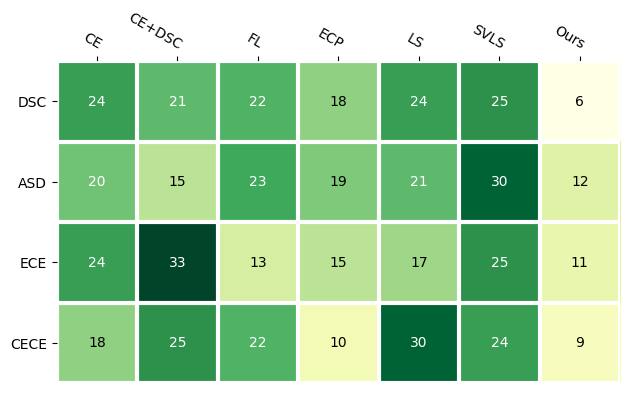

In [33]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # # Create colorbar
    # cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    # cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


harvest = np.array([[24,21,22,18,24,25,6], ## rank_dsc
                    [20,15,23,19,21,30,12], ## rank_asd
                    [24,33,13,15,17,25,11], ## rank_ece
                    [18,25,22,10,30,24,9]]) ## rank_cece)
vegetables = ["DSC", "ASD", "ECE", "CECE"]
farmers = ['CE','CE+DSC','FL','ECP','LS','SVLS','Ours']
plt.style.use('default')
fig, ax = plt.subplots()
im, cbar = heatmap(harvest, vegetables, farmers, ax=ax, cmap="YlGn", cbarlabel="rank")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

fig.tight_layout()
# plt.savefig('../../figures_mbls/rank_heatmap.pdf')
plt.show()